## CNN Model for Image Classification.

ใช้โมเดล Convolutional Neural Network (CNN) 
สำหรับการจำแนกภาพ(image classification) 

### หลักการทำงานของ Convolutional Neural Network (CNN) 

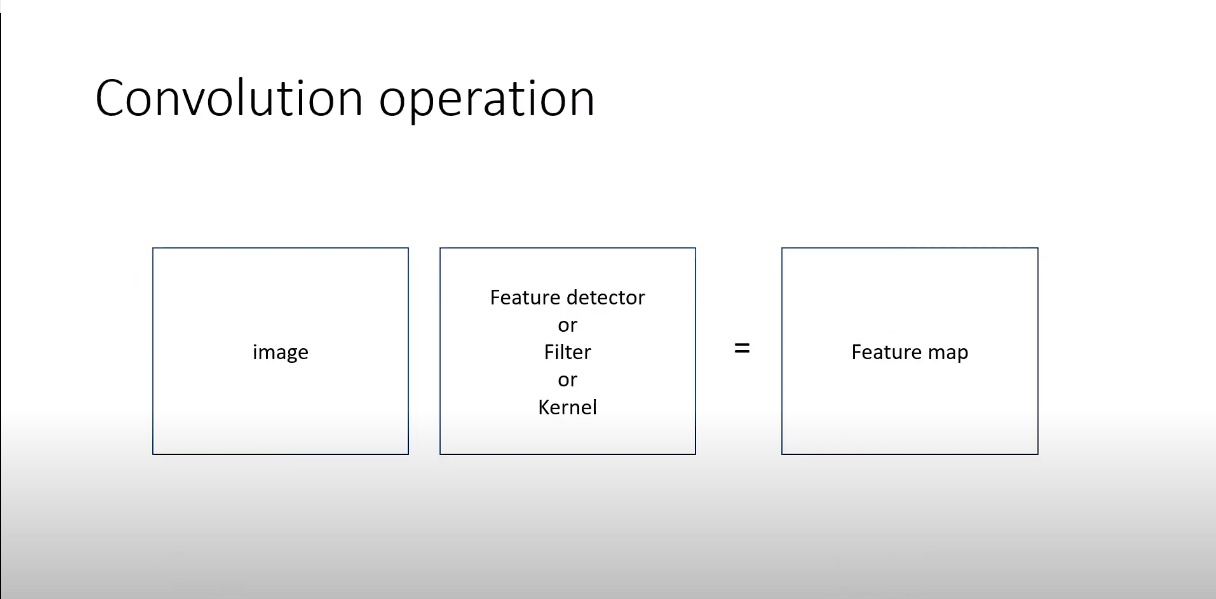

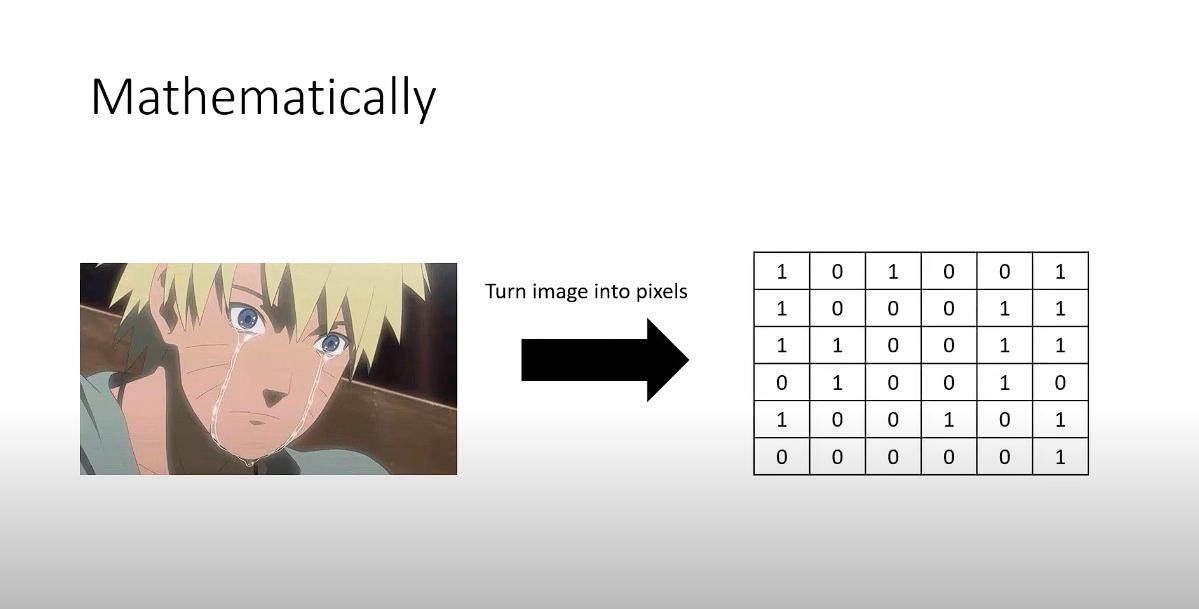

CNN จะนำ Feature detector ไปสแกนลงบนรูปภาพจากนั้นโมเดลก็สามารถรู้ได้ว่ารูปภาพที่เป็นโรคข้อกระดูกหรือไม่เป็น



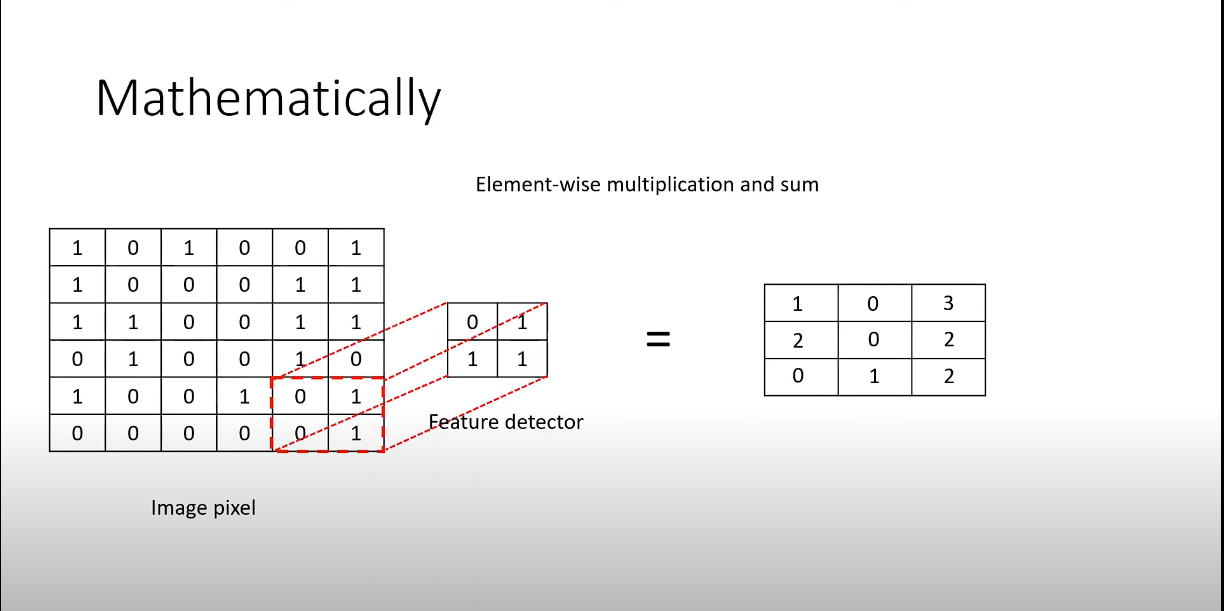

เปลี่ยนรูปภาพเป็น pixel ขนาดตามที่กำหนด แล้วเอา feature detector ไปคูณกับ image pixel จากนั้นมารวมผลลัพธ์

Feature detector คือรูปที่เป็นโรคกระดูกพรุน


ผลลัพธ์จากการเอา (feature detector * image pixel) + ผลลัพธ์ 

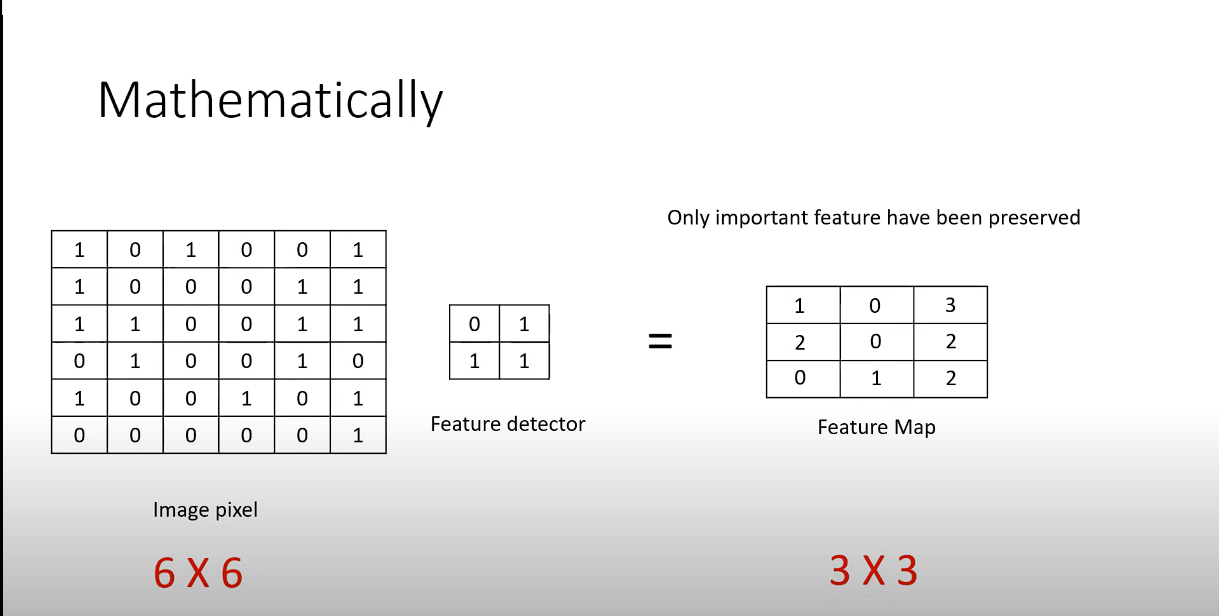

ถ้าค่าใน Feature Map เยอะก็แสดงว่า match กัน ถ้าเป็น 0 ก็แสดงว่าไม่ match กัน ซึ่งทำให้ CNN จะสนใจแค่ Feature ที่สำคัญ

1. Convolutional Layers (Conv Layers): จะใช้ Feature Detector เพื่อสแกนบนรูปภาพ และนำเอาfeatureที่มีความสำคัญของรูปภาพมาทำเป็น Feature Maps หรือ Activation Maps โดย Feature Detector จะเป็นตัวfilter ที่มีลักษณะต่างๆ  เช่น การหาขอบ (edge detection), การจับแนว (line detection), และลักษณะอื่นๆ ที่สำคัญในการจำแนกภาพ

2. Pooling Layers: จะช่วยลดขนาดข้อมูลที่ได้จาก Conv Layers ด้วยการเลือกค่าสำคัญ (max pooling) หรือการเฉลี่ยค่า (average pooling) ที่มีผลในการลดความซับซ้อนและเวลาในการทำงานของโมเดล

3. Fully Connected Layers: เป็นชั้นที่เชื่อมต่อค่าที่ได้จาก Convolutional Layers ไปยังชั้นการจำแนกที่ใช้ในการตัดสินใจว่าภาพนั้นเป็นรูปภาพของคลาสไหน เช่น "โรค" หรือ "ปกติ"

4. Softmax Activation Layer: ใช้ในการแปลงค่าของชั้น Fully Connected Layer เป็นค่าความน่าจะเป็น (probability) สำหรับแต่ละคลาส เพื่อให้แบบจำลองสามารถทำนายคลาสของภาพได้

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score


import tensorflow as tf
from tensorflow import keras

from keras.utils import load_img, img_to_array
from keras.layers import *
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications import ResNet50


from tensorflow.keras import backend as K 
#ใช้ในการจัดการกับพื้นหลังของ keras เช่น TensorFlow,theano,CNTK ใช้จัดการขนาด tensor,การคำนวน gradient,การทำ one-hot encoding

from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam, Adamax 
#ใช้ในการปรับแต่ง parametor ของ model 
#Adam: ช่วยลดปัญหาการเรียนรู้ที่ช้าลงเมื่อใกล้สิ้นสุดการ train adam มีการทำ adaptive learning rate และ momentum ซึ่งช่วยในการเร่งการอัปเดต
#Adamax: คล้ายกับ adam แต่มีการปรับในการคำนวน learning rate โดยการใช้ side-by-side path ของแต่ละ parameter ทำให้ 'adamax' เหมาะกับการฝึกmodel ที่มีจำนวนมากของparameter

from tensorflow.keras.preprocessing.image import ImageDataGenerator #ใช้ในการเตรียมข้อมูลภาพ  

from tensorflow.keras.models import Model, Sequential
#Sequential model:มี layer เรียงต่อกันเป็นลำดับ ใช้สำหรับ CNN 
#Model :ไม่จำเป็นต้องเรียงลำดับด้วยการระบุชั้นที่เชื่อมต่อกันเป็นกราฟและสามารถแบ่งแยกและรวมกันของชั้นได้ตามความต้องการ 



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imutils/imutils-0.5.3/setup.cfg
/kaggle/input/imutils/imutils-0.5.3/PKG-INFO
/kaggle/input/imutils/imutils-0.5.3/setup.py
/kaggle/input/imutils/imutils-0.5.3/imutils/meta.py
/kaggle/input/imutils/imutils-0.5.3/imutils/contours.py
/kaggle/input/imutils/imutils-0.5.3/imutils/object_detection.py
/kaggle/input/imutils/imutils-0.5.3/imutils/paths.py
/kaggle/input/imutils/imutils-0.5.3/imutils/convenience.py
/kaggle/input/imutils/imutils-0.5.3/imutils/encodings.py
/kaggle/input/imutils/imutils-0.5.3/imutils/perspective.py
/kaggle/input/imutils/imutils-0.5.3/imutils/__init__.py
/kaggle/input/imutils/imutils-0.5.3/imutils/text.py
/kaggle/input/imutils/imutils-0.5.3/imutils/feature/factories.py
/kaggle/input/imutils/imutils-0.5.3/imutils/feature/gftt.py
/kaggle/input/imutils/imutils-0.5.3/imutils/feature/rootsift.py
/kaggle/input/imutils/imutils-0.5.3/imutils/feature/dense.py
/kaggle/input/imutils/imutils-0.5.3/imutils/feature/helpers.py
/kaggle/input/imutils/imutils-0.5.3/imutils

In [3]:
normal_dir = r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal'
osteo_dir = r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis'

filepaths = []
labels = []

def read_images(directory, label):
    flist = os.listdir(directory)
    for f in flist:
        fpath = os.path.join(directory, f)
        filepaths.append(fpath)
        labels.append(label)
    
read_images(normal_dir, "Normal")
read_images(osteo_dir, "Osteoporosis")

print("Total number of images:", len(labels))

Total number of images: 372


## Add files to dataframe

In [4]:
image_f = pd.Series(filepaths, name='filepaths')
image_l = pd.Series(labels, name='labels')

In [5]:
df = pd.concat([image_f, image_l], axis=1)
df.head()

,filepaths,labels
0,/kaggle/input/osteoporosis-knee-xray-dataset/n...,Normal
1,/kaggle/input/osteoporosis-knee-xray-dataset/n...,Normal
2,/kaggle/input/osteoporosis-knee-xray-dataset/n...,Normal
3,/kaggle/input/osteoporosis-knee-xray-dataset/n...,Normal
4,/kaggle/input/osteoporosis-knee-xray-dataset/n...,Normal


In [6]:
df['labels'].value_counts()

Normal          186
Osteoporosis    186
Name: labels, dtype: int64

## Feature Selection


In [7]:
height = 200
width = 400
channels = 3 #จำนวนช่องสีของรูปภาพ RGB
batch_size = 80 #ขนาดของแต่ละกลุ่มรูปภาพสำหรับการฝึกแบบ mini-batch gradient descent
img_shape = (height, width, channels)
img_size = (height, width)
train_split = 0.9
test_split = 0.05

In [8]:
dummy_split = test_split/(1-train_split)
train_df, dummy_df = train_test_split(df, train_size = train_split, shuffle = True, random_state = 123)
test_df, valid_df = train_test_split(dummy_df, 
                                     train_size = dummy_split, 
                                     shuffle = True, 
                                     random_state = 123)
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df)) #vaild_df เป็นชุดข้อมูลที่ถูกแบ่งออกมาจาก training set เพื่อตรวจสอบและประเมินโมเดลจากข้อมูลที่ไม่เคยเห็นมาก่อน 

train samples:  334   test samples:  19  validation samples 19


In [9]:
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]

test_steps = int(length/test_batch_size)
print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  19   test steps:  1


### การเตรียมข้อมูลภาพ ImageDataGenerator 
data augumentation การเพิ่มข้อมูลจาก module ImageDataGenerator ที่ใช้ในการ process รูปภาพ 

1. การปรับขนาดภาพ(Resizing) 
2. การป้อนข้อมูลแบบ Batch (Batch feeding)ส่งข้อมูลเข้าไปในโมเดลเป็นชุดๆเพื่อให้เพียงพอกับ ram 
3. การปรับสีและความคมชัด(Color and Sharpness Adjustments)
4. Data Augmentation(การเพิ่มข้อมูลแบบสุ่ม)การสร้างภาพซ้ำๆจากภาพเดิมโดยมีการปรับ เช่น การหมุนภาพ สะท้อนภาพ เพื่อลดการเกิด overfiting และเพื่อเพิ่มประสิทธิภาพในการ train model
5. การปรับความสมดุล (Balancing) ในกรณีที่ข้อมูลของ class มีจำนวนไม่เท่ากัน module นี้จะช่วยสร้างภาพเพิ่มเติมของ class ที่มีจำนวนน้อยเพื่อปรับให้สมดุลกัน
6. Normalization ทำการปรับค่าความเข้มแสงของ pixel ให้เป็นช่วงที่กำหนด เช่น [0,1]

### Training set

In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,  #การปรับค่าสีของรูปภาพให้อยู่ในช่วง [0, 1] เพื่อให้ขนาดเท่ากัน
    rotation_range = 20, #หมุนรูปภาพในองศาระหว่าง -20 ถึง 20
    width_shift_range=0.2, #เลื่อนรูปภาพในแนวนอนช่วง -0.2 ถึง 0.2
    height_shift_range = 0.2,
    shear_range = 0.2, # เอียงรูปภาพ
    zoom_range = 0.2, # ซูมรูปภาพ
    horizontal_flip = True, # พลิกภาพแนวนอน
    fill_mode = 'nearest') #เติมพื้นหลังจากการทำ data augmentation

In [11]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle=False,
    batch_size = batch_size)

Found 334 validated image filenames belonging to 2 classes.


### Test set

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle=False,
    batch_size = test_batch_size) # ระบุขนาดของกลุ่มย่อยที่จะนำเข้าmodel แต่ละครั้ง

Found 19 validated image filenames belonging to 2 classes.


### Validation set

In [13]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle=False, 
    batch_size = batch_size) 

Found 19 validated image filenames belonging to 2 classes.


### คำนวณจำนวนขั้นตอนในการฝึก (training steps)

In [14]:
classes = list(train_gen.class_indices.keys())
classes

['Normal', 'Osteoporosis']

In [15]:
class_count = len(classes)
class_count

2

In [16]:
train_steps = int(len(train_gen.labels)/batch_size)
train_steps

4

In [17]:
len(train_gen.labels)

334

## EDA

In [18]:
def show_image_samples(gen, class_names):
    class_dict = gen.class_indices
    new_dict = {}
    
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value] = key        
        
    images, labels = next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = 15
    
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='purple', fontsize=16)
        plt.axis('on')
    plt.show()

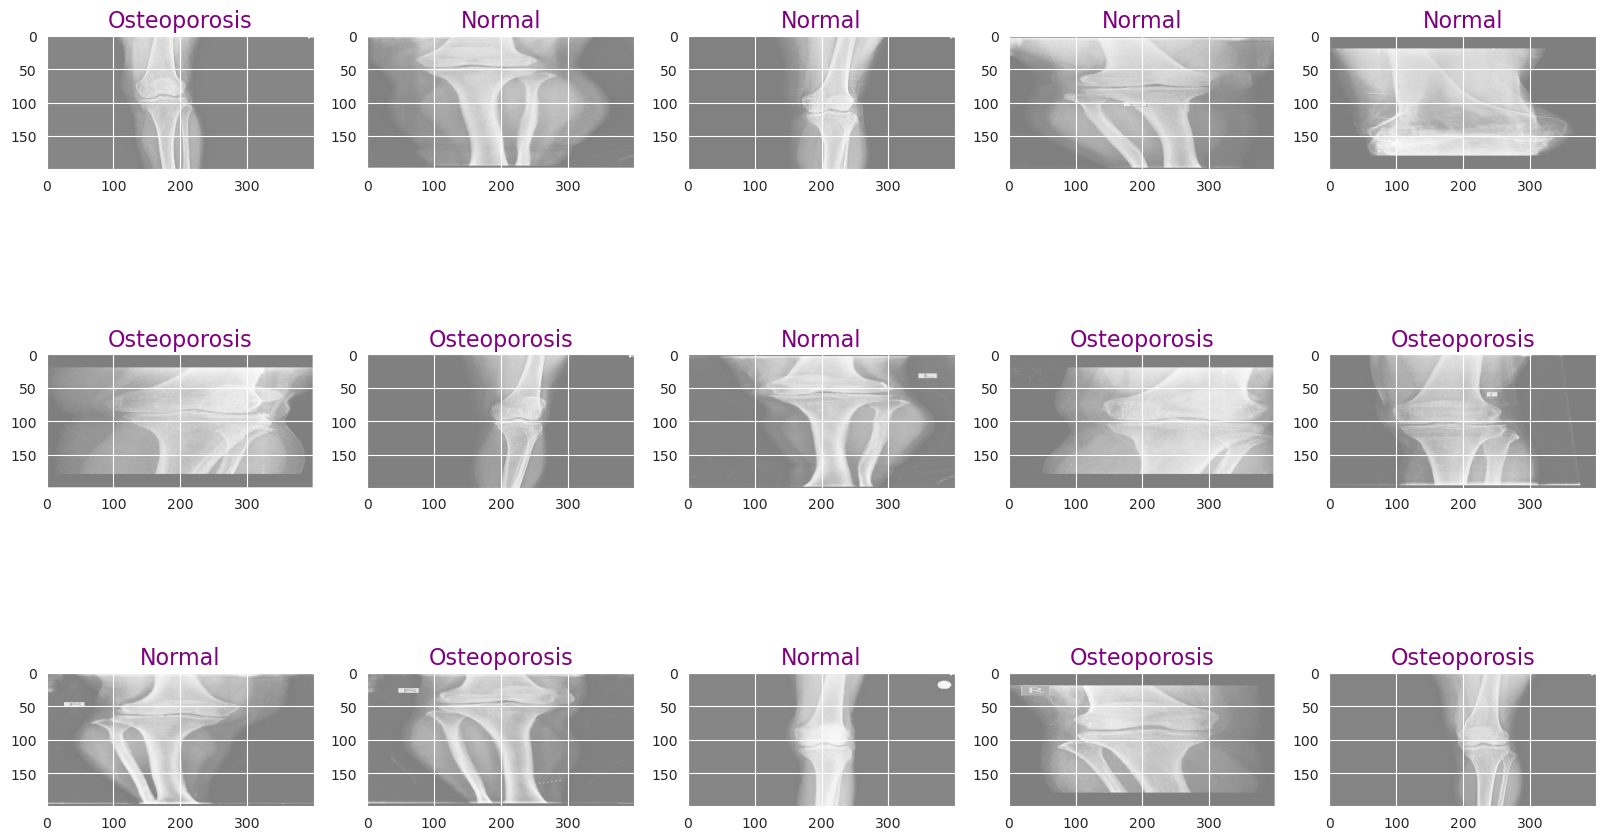

In [19]:
show_image_samples(test_gen, classes)

## Keres Model

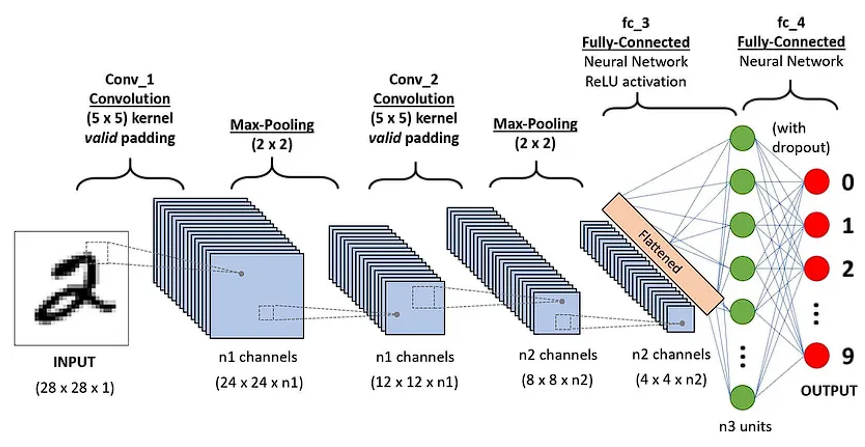

### CNN MODEL

In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_shape), # ชั้น Convolutional แรกที่มี 32 ตัวกรองขนาด 3x3 / input_shape = ขนาดความกว้าง ยาว และ rgb
    MaxPooling2D((2, 2)), # ตารางขนาด 2x2 เพื่อลดขนาดของรูปภาพ
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)), 
    Flatten(), #ชั้น Flatten เพื่อแปลงข้อมูลรูปภาพที่มีมิติมากเป็นเวกเตอร์หนึ่งมิติ
    Dense(64, activation='relu'), #ชั้น Fully Connected ที่มี 64 โหนด
    Dense(class_count, activation='sigmoid') #ชั้น Fully Connected สุดท้ายที่มีโหนดเท่ากับจำนวน class ในชุดข้อมูล 
                                            #และใช้ Sigmoid เป็นฟังก์ชัน activation ใช้จำแนก class
])

#สร้างโมเดล CNN ด้วย keras ใช้ Sequential หรือ Fucional API สร้างชั้นของโมเดลที่ต่างกัน
1. Dense: เป็นชั้นที่ทำหน้าที่เป็น fully connected layer ในmodel เมื่อเรียกใช้ 'Dense(units, activation)' จะสร้างชั้นที่มีจำนวน units(หรือ neurons)
2. Auctication :เป็นชั้นเพิ่มฟังก์ชัน เช่น ReLU 
3. Dropout: เป็นชั้นป้องกันการเกิด overfitting โดยการปิดการทำงานบางส่วนของ neurons ในชั้นก่อนไปชั้นถัดไป เช่น 'Dropout(0.5)' คือปิดการทำงาน 50% ของ neurons
4. Conv2D: เป็นชั้น convolutional layer ที่ใช้ในการค้นหาลายเส้นและ feature ของภาพโดยกำหนดจำนวน filters,ขนาดของ fillters,และ activation funtion เช่น 'Conv2D(filters, kernal_size, activation)'
5. MaxPooling2D :เป็นชั้น max pooling layer ใช้ในการลดขนาดของภาพและคัดเลือก feature สำคัญจากส่วนของภาพ โดยระบุขนาดของ pooling window 
6. BatchNormalization :เป็นชั้นที่ใช้ในการปรับปรุงการกระจายข้อมูลในชั้นให้มี mean ใกล้เคียง 0 และ standard deviation ใกล้เคียง 1 ซึ่งช่วยในการลดปัญหาการ learn ที่ไม่เสถียร
7. Flatten: เป็นชั้นที่ใช้ในการแปลงข้อมูลจากภาพหรือข้อมูลที่มีมิติสูง เช่น ข้อมูลภาพ ให้อยู่ในรูปแบบ vector สำหรับการนำเข้าชั้น fully connected
8. GlobalAveragePooling2D: เป็นชั้นที่ใช้ในการทำ average pooling ทั้งรูปภาพ และหลายช่อง feature เพื่อลดขนาดข้อมูฃก่อนนำเข้าชั้น fully connected

In [21]:
# Compile the model 
model.compile(
    optimizer = Adam(),  # ช่วยลดปัญหาการเรียนรู้ที่ช้าลงตอนใกล้จบการ train มันจะทำ adaptive learning rate และ momentum ช่วยในการเร่งการอัปเดต
    loss = "binary_crossentropy",  
    metrics = ["accuracy"]  
)

In [22]:
# Train the model
history = model.fit(
    train_gen,  # ข้อมูลที่ train และ process จาก ImageDataGenerator
    validation_data = valid_gen, #ชุดข้อมูลที่ใช้ตรวจประสิทธิภาพ model ขณะที่ train จะช่วยดูว่าmodel ที่ฝึกแล้วมีความแม่นยำกับข้อมูลที่ไม่เคยเห็นมาก่อนรึเปล่า
    epochs=10,  # รอบในการ train
)

Epoch 1/10
5/5 [==============================] - 38s 6s/step - loss: 2.2739 - accuracy: 0.4940 - val_loss: 0.7667 - val_accuracy: 0.5263
Epoch 2/10
5/5 [==============================] - 36s 6s/step - loss: 0.7615 - accuracy: 0.5030 - val_loss: 0.6998 - val_accuracy: 0.4737
Epoch 3/10
5/5 [==============================] - 34s 8s/step - loss: 0.6939 - accuracy: 0.5509 - val_loss: 0.6933 - val_accuracy: 0.5789
Epoch 4/10
5/5 [==============================] - 34s 8s/step - loss: 0.6931 - accuracy: 0.5479 - val_loss: 0.6914 - val_accuracy: 0.6842
Epoch 5/10
5/5 [==============================] - 34s 8s/step - loss: 0.6934 - accuracy: 0.5090 - val_loss: 0.6854 - val_accuracy: 0.5263
Epoch 6/10
5/5 [==============================] - 34s 6s/step - loss: 0.6918 - accuracy: 0.5150 - val_loss: 0.6938 - val_accuracy: 0.5789
Epoch 7/10
5/5 [==============================] - 36s 7s/step - loss: 0.6911 - accuracy: 0.5928 - val_loss: 0.6915 - val_accuracy: 0.4211
Epoch 8/10
5/5 [==================

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 199, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 197, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 98, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 301056)            0         
                                                                 
 dense (Dense)               (None, 64)                1

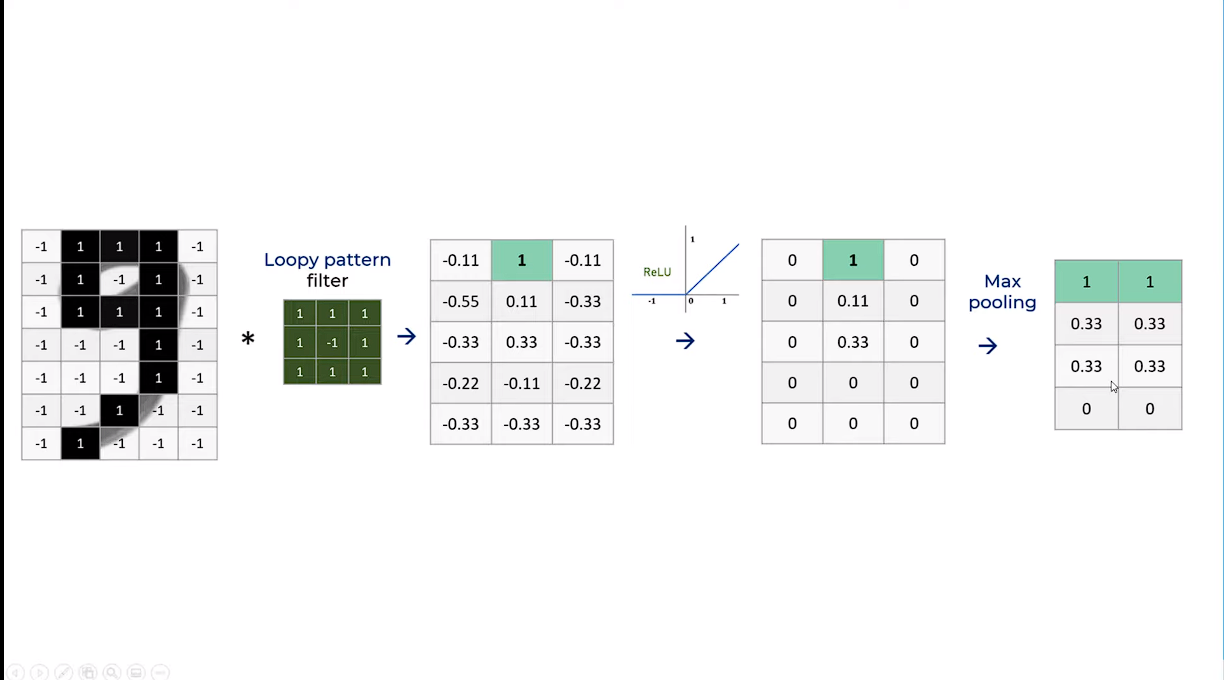

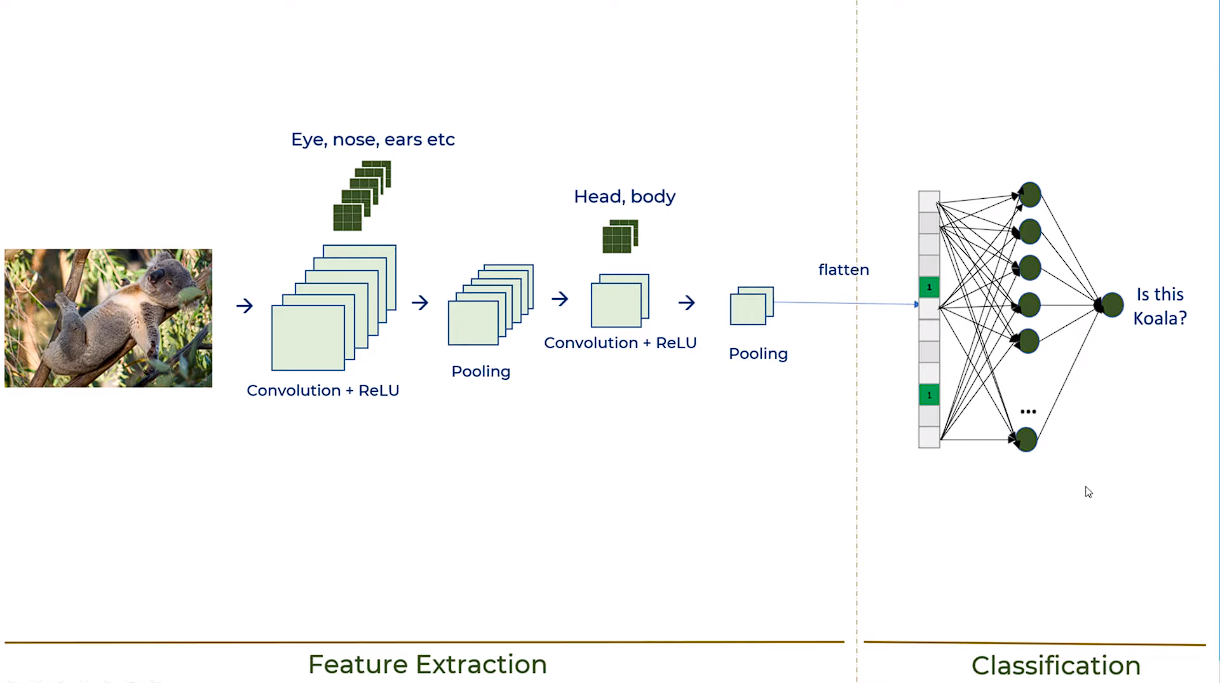

- 1. Feature extraction เสร็จจะได้ feature ที่ผ่านการ pooling(เลือกแค่ส่วนสำคัญของรูป) ของรูปออกมาเป็น matrix
- 2. Classification และ encode feature จะรับ feature ที่เป็น matrix และใช้ encode feature แปลงให้เป็น vector
- 3. Dense layer ตัวทำนายภาพ output คือ weight กับ bias
- 4. activation funtion เพื่อแปลง output ให้อยู่ในรูปความน่าจะเป็น


- (ถ้าต้องการจะปรับตัวทำนาย classification คือต้องปรับตัว Dense layer และinput ที่ รับเข้าไปคือ Matrix และ encode feature ออกมาเป็น vector(ใช้วิธี flatten) 


In [24]:
import numpy as np

img_data_list = []

for img_path in filepaths:
    img = load_img(img_path, target_size=(224, 224))
    img_data = img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    img_data_list.append(img_data)

# img_data_list ตอนนี้เป็นรายการของรูปภาพที่ถูกปรับขนาดและทำความสะอาดแล้ว


In [25]:
img_path = '/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis/55.JPEG'
img = load_img(img_path, target_size=(224, 224))
img_data = img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)  # Preprocess the image

In [26]:
img_data

array([[[[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-102.939, -115.779, -122.68 ],
         [ -97.939, -110.779, -117.68 ]],

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ]],

        ...,

        [[-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         [-103.939, -116.779, -123.68 ],
         ...,
         [-103.939, -116.779, -123.68 ],
         [-103.939, -1

In [27]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), input_shape=(224, 224, 3), padding='VALID'))
model.add(Conv2D(64, kernel_size=(3,3), padding='VALID'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 2
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation ='relu', padding='VALID'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, activation ='relu', padding='VALID'))
model.add(AveragePooling2D(pool_size=(19, 19)))

# set of FC => RELU layers
model.add(Flatten())

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 106, 106, 128)     147584    
                                                                 
 average_pooling2d (AverageP  (None, 5, 5, 128)        0         
 ooling2D)                                            

In [28]:
feature_vector = model.predict(img_data)

1/1 [==============================] - 0s 216ms/step


In [29]:
print("Feature vector shape:", feature_vector.shape)

Feature vector shape: (1, 3200)


In [30]:
print("Feature vector feature:", feature_vector)

Feature vector feature: [[7.4349756e+00 1.9848715e+01 2.4862866e+00 ... 5.9105659e+00
  6.5606523e+00 2.5349838e-04]]


# Extracting Features with a Pre-trained CNN





In [31]:
import h5py
import os

import random
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [32]:
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
    # check to see if the output path exists, and if so, raise
    # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied ‘outputPath‘ already "
         "exists and cannot be overwritten. Manually delete "
         "the file before continuing.", outputPath)

         # open the HDF5 database for writing and create two datasets:
         # one to store the images/features and another to store the
         # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0],),dtype="int")

         # store the buffer size, then initialize the buffer itself
         # along with the ind
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0
    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)
        
        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()
    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}
    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype()
        labelSet = self.db.create_dataset("label_names",
        (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels
    def close(self):
         # check to see if there are any other entries in the buffer
         # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()
        
         # close the dataset
        self.db.close()

In [33]:
osteoporosis_dataset_path = r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis'
normal_dataset_path = r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal'

osteoporosis_hdf5_path = 'osteoporosis_features.hdf5'
normal_hdf5_path = 'normal_features.hdf5'

batch_size = 32
buffer = 1000

### Extracting Features From Osteoporosis

In [34]:
!cp -r ../input/imutils/imutils-0.5.3/ /
!pip install /imutils-0.5.3/

Processing /imutils-0.5.3
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25851 sha256=4c12ca417b2a159b445648deb31f27e77b25fbbfa89b653c90e7b1bb812b9b9e
  Stored in directory: /root/.cache/pip/wheels/6f/b3/14/d7ad7d86839648e57bc19927983760a768523f44cebaef75f1
Successfully built imutils


In [35]:
import progressbar
import random
from sklearn.preprocessing import LabelEncoder
from imutils import paths

In [36]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(osteoporosis_dataset_path))
random.shuffle(imagePaths)

[INFO] loading images...


In [37]:
# extract the class labels from the image paths then encode the labels
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
le = LabelEncoder()
labels = le.fit_transform(labels)

In [38]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
weights_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG16(weights=weights_path, include_top=False)
random.shuffle(imagePaths)

In [40]:
if os.path.exists(osteoporosis_hdf5_path):
    # ถ้ามีให้ลบไฟล์
    os.remove(osteoporosis_hdf5_path)
    
dataset = HDF5DatasetWriter((len(imagePaths), 512 * 7 * 7), osteoporosis_hdf5_path, dataKey="features")

# Loop over the images in patches
for i in tqdm(range(0, len(imagePaths), batch_size)):
    # Extract the batch of images and labels, then initialize the
    # list of actual images that will be passed through the network
    # for feature extraction
    batchPaths = imagePaths[i:i + batch_size]
    batchLabels = labels[i:i + batch_size]
    batchImages = []

    # Loop over the images and labels in the current batch
    for (j, imagePath) in enumerate(batchPaths):
        # Load the input image using the Keras helper utility
        # while ensuring the image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # Preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)

        # Add the image to the batch
        batchImages.append(image)

    batchImages = np.vstack(batchImages)
    features = model.predict(batchImages, batch_size=batch_size)

    # Reshape the features so that each image is represented by
    # a flattened feature vector of the ‘MaxPooling2D‘ outputs
    features = features.reshape((features.shape[0], 512 * 7 * 7))

    # Add the features and labels to our HDF5 dataset
    dataset.add(features, batchLabels)

dataset.close()

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


 17%|█▋        | 1/6 [00:09<00:49,  9.83s/it]

1/1 [==============================] - 9s 9s/step


 33%|███▎      | 2/6 [00:19<00:39,  9.97s/it]

1/1 [==============================] - 9s 9s/step


 50%|█████     | 3/6 [00:29<00:29,  9.79s/it]

1/1 [==============================] - 9s 9s/step


 67%|██████▋   | 4/6 [00:38<00:19,  9.68s/it]

1/1 [==============================] - 9s 9s/step


 83%|████████▎ | 5/6 [00:48<00:09,  9.78s/it]

1/1 [==============================] - 7s 7s/step


100%|██████████| 6/6 [00:56<00:00,  9.47s/it]


In [41]:
with h5py.File(osteoporosis_hdf5_path, "r") as hdf5_file:
    
    features_osteoporosis = hdf5_file["features"][:]
    labels_ostroporosis = hdf5_file["labels"][:]


print("Feature vectors Osteoporosis shape:", features_osteoporosis.shape)
print("Labels Osteoporosis shape:", labels_ostroporosis.shape)

Feature vectors Osteoporosis shape: (186, 25088)
Labels Osteoporosis shape: (186,)


In [42]:
features_osteoporosis

array([[0.        , 0.        , 0.        , ..., 3.48360395, 0.3289482 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 8.27648449,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 7.97655678,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Extracting Features From normal

In [43]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(normal_dataset_path ))
random.shuffle(imagePaths)

[INFO] loading images...


In [44]:
# extract the class labels from the image paths then encode the
# labels
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
le = LabelEncoder()
labels = le.fit_transform(labels)

In [45]:
weights_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG16(weights=weights_path, include_top=False)
random.shuffle(imagePaths)

In [46]:
if os.path.exists(normal_hdf5_path):
    # ถ้ามีให้ลบไฟล์
    os.remove(normal_hdf5_path)
    
dataset = HDF5DatasetWriter((len(imagePaths), 512 * 7 * 7), normal_hdf5_path, dataKey="features")

# Loop over the images in patches
for i in tqdm(range(0, len(imagePaths), batch_size)):
    # Extract the batch of images and labels, then initialize the
    # list of actual images that will be passed through the network
    # for feature extraction
    batchPaths = imagePaths[i:i + batch_size]
    batchLabels = labels[i:i + batch_size]
    batchImages = []

    # Loop over the images and labels in the current batch
    for (j, imagePath) in enumerate(batchPaths):
        # Load the input image using the Keras helper utility
        # while ensuring the image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # Preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)

        # Add the image to the batch
        batchImages.append(image)

    batchImages = np.vstack(batchImages)
    features = model.predict(batchImages, batch_size=batch_size)

    # Reshape the features so that each image is represented by
    # a flattened feature vector of the ‘MaxPooling2D‘ outputs
    features = features.reshape((features.shape[0], 512 * 7 * 7))

    # Add the features and labels to our HDF5 dataset
    dataset.add(features, batchLabels)

dataset.close()

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


 17%|█▋        | 1/6 [00:09<00:49,  9.94s/it]

1/1 [==============================] - 9s 9s/step


 33%|███▎      | 2/6 [00:19<00:39,  9.91s/it]

1/1 [==============================] - 9s 9s/step


 50%|█████     | 3/6 [00:30<00:30, 10.12s/it]

1/1 [==============================] - 9s 9s/step


 67%|██████▋   | 4/6 [00:40<00:19, 10.00s/it]

1/1 [==============================] - 9s 9s/step


 83%|████████▎ | 5/6 [00:49<00:09,  9.92s/it]

1/1 [==============================] - 8s 8s/step


100%|██████████| 6/6 [00:58<00:00,  9.76s/it]


In [47]:
with h5py.File(normal_hdf5_path, "r") as hdf5_file:
    
    features_normal = hdf5_file["features"][:]
    labels_normal = hdf5_file["labels"][:]


print("Feature vectors normal shape:", features_normal.shape)
print("Labels normal shape:", labels_normal.shape)

Feature vectors normal shape: (186, 25088)
Labels normal shape: (186,)


In [48]:
print(features_normal[10])

[4.30921173 0.         0.         ... 0.         0.         0.        ]


In [49]:
print(features_osteoporosis[2][:100]) 

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         17.69397545  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          2.10904837  0.84128773  0.          0.         16.32036972
  0.          0.          0.          0.          0.          0.
  0.          0.          0.78259516  0.          0.          0.
  0.          0.         69.69538879  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.42427999
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.     

## วิธีที่ 2 เพิ่ม Labels (0,1 | 1,0)


In [50]:
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
    # check to see if the output path exists, and if so, raise
    # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied ‘outputPath‘ already "
         "exists and cannot be overwritten. Manually delete "
         "the file before continuing.", outputPath)

         # open the HDF5 database for writing and create two datasets:
         # one to store the images/features and another to store the
         # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,dtype="float")
        self.labels = np.zeros((dims[0], 2),dtype= int)

         # store the buffer size, then initialize the buffer itself
         # along with the ind
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0
    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)
        
        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()
    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}
    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype()
        labelSet = self.db.create_dataset("label_names",
        (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels
    def close(self):
         # check to see if there are any other entries in the buffer
         # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()
        
         # close the dataset
        self.db.close()

In [51]:
osteoporosis_dataset_path = r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis'
normal_dataset_path = r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal'

osteoporosis_hdf5_path = 'osteoporosis_features.hdf5'
normal_hdf5_path = 'normal_features.hdf5'

batch_size = 32
buffer = 1000

### Extracting Features From Osteoporosis

In [52]:
print("[INFO] loading images...")
imagePaths= list(paths.list_images(osteoporosis_dataset_path))
random.shuffle(imagePaths)

[INFO] loading images...


## สร้าง label โดยใช้ลำดับของ feature vectors ใน A


In [53]:
labels_osteoporosis = [[1,0]for _ in imagePaths]

In [54]:
weights_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG16(weights=weights_path, include_top=False)
random.shuffle(imagePaths)

In [ ]:
# เปิด HDF5 dataset writer
if os.path.exists(osteoporosis_hdf5_path):
    os.remove(osteoporosis_hdf5_path)
    
dataset = HDF5DatasetWriter((len(imagePaths), 512 * 7 * 7), osteoporosis_hdf5_path, dataKey="features")

# Loop over the images in patches
for i in tqdm(range(0, len(imagePaths), batch_size)):
    # Extract the batch of images and labels, then initialize the
    # list of actual images that will be passed through the network
    # for feature extraction
    batchPaths = imagePaths[i:i + batch_size]
    batchLabels = labels[i:i + batch_size]
    batchImages = []

    # Loop over the images and labels in the current batch
    for (j, imagePath) in enumerate(batchPaths):
        # Load the input image using the Keras helper utility
        # while ensuring the image is resized to 224x224 pixels
        
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # Preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)

        # Add the image to the batch
        batchImages.append(image)

    batchImages = np.vstack(batchImages)
    features = model.predict(batchImages, batch_size=batch_size)

    # Reshape the features so that each image is represented by 
    # a flattened feature vector of the ‘MaxPooling2D‘ outputs
    features = features.reshape((features.shape[0], 512 * 7 * 7))

    # Add the features and labels to our HDF5 dataset
    dataset.add(features, batchLabels)

dataset.close()

In [ ]:
with h5py.File(osteoporosis_hdf5_path, "r") as hdf5_file:
    print(list(hdf5_file.keys()))

In [ ]:
with h5py.File(osteoporosis_hdf5_path, "r") as hdf5_file:
    features_osteoporosis = hdf5_file["features"][:]
    

print("Feature vectors Osteoporosis shape:", features_osteoporosis.shape)

In [ ]:
features_osteoporosis[1][:100]

### Extracting Features From normal

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(normal_dataset_path))
random.shuffle(imagePaths)

In [ ]:
labels_normal = [[0,1]for _ in imagePaths]

In [ ]:
labels_normal[0]

In [ ]:
weights_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG16(weights=weights_path, include_top=False)
random.shuffle(imagePaths)

In [ ]:
# เปิด HDF5 dataset writer
if os.path.exists(normal_hdf5_path):
    os.remove(normal_hdf5_path)
    
dataset = HDF5DatasetWriter((len(imagePaths), 512 * 7 * 7), normal_hdf5_path, dataKey="features")

# Loop over the images in patches
for i in tqdm(range(0, len(imagePaths), batch_size)):
    # Extract the batch of images and labels, then initialize the
    # list of actual images that will be passed through the network
    # for feature extraction
    batchPaths = imagePaths[i:i + batch_size]
    batchLabels = labels[i:i + batch_size]
    batchImages = []

    # Loop over the images and labels in the current batch
    for (j, imagePath) in enumerate(batchPaths):
        # Load the input image using the Keras helper utility
        # while ensuring the image is resized to 224x224 pixels
        
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # Preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)

        # Add the image to the batch
        batchImages.append(image)

    batchImages = np.vstack(batchImages)
    features = model.predict(batchImages, batch_size=batch_size)

    # Reshape the features so that each image is represented by 
    # a flattened feature vector of the ‘MaxPooling2D‘ outputs
    features = features.reshape((features.shape[0], 512 * 7 * 7))

    # Add the features and labels to our HDF5 dataset
    dataset.add(features, batchLabels)

dataset.close()

In [ ]:
with h5py.File(normal_hdf5_path, "r") as hdf5_file:
    print(list(hdf5_file.keys()))

In [ ]:
with h5py.File(normal_hdf5_path, "r") as hdf5_file:
    features_normal = hdf5_file["features"][:]
    
print("Feature vectors Normal shape:", features_normal.shape)

In [ ]:
features_normal[1][:100]

In [ ]:
features_osteoporosis

In [ ]:
with h5py.File(osteoporosis_hdf5_path, "r") as hdf5_file:
    features_osteoporosis = hdf5_file["features"][:]
    
print("Feature vectors osteoporosis shape:", features_osteoporosis.shape)

## feature และ label ที่สกัด

In [ ]:
labels_normal[0]

In [ ]:
labels_osteoporosis[0]